## Exploratory Data Analysis


Before creating a classification algorithm, it is essential to understand the dataset better.

In [7]:
## Import necessary libraries
import os
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np


In [4]:
## Set the path to the dataset
DATA_PATH = 'architectural-styles-dataset'  # Replace with your dataset path

## Get the list of architectural styles (folders in the directory)
styles = [folder for folder in os.listdir(DATA_PATH) if not folder.startswith('.')]
print(f"Found {len(styles)} architectural styles: {styles}")

Found 25 architectural styles: ['Palladian architecture', 'Novelty architecture', 'International style', 'Chicago school architecture', 'Beaux-Arts architecture', 'Ancient Egyptian architecture', 'Gothic architecture', 'Tudor Revival architecture', 'Romanesque architecture', 'Colonial architecture', 'American craftsman style', 'Greek Revival architecture', 'Queen Anne architecture', 'Baroque architecture', 'Edwardian architecture', 'Art Nouveau architecture', 'Deconstructivism', 'Bauhaus architecture', 'Georgian architecture', 'Byzantine architecture', 'Postmodern architecture', 'Achaemenid architecture', 'Art Deco architecture', 'American Foursquare architecture', 'Russian Revival architecture']


In [5]:
## Check the number of images in each style
style_counts = {}
for style in styles:
    style_counts[style] = len(os.listdir(os.path.join(DATA_PATH, style)))

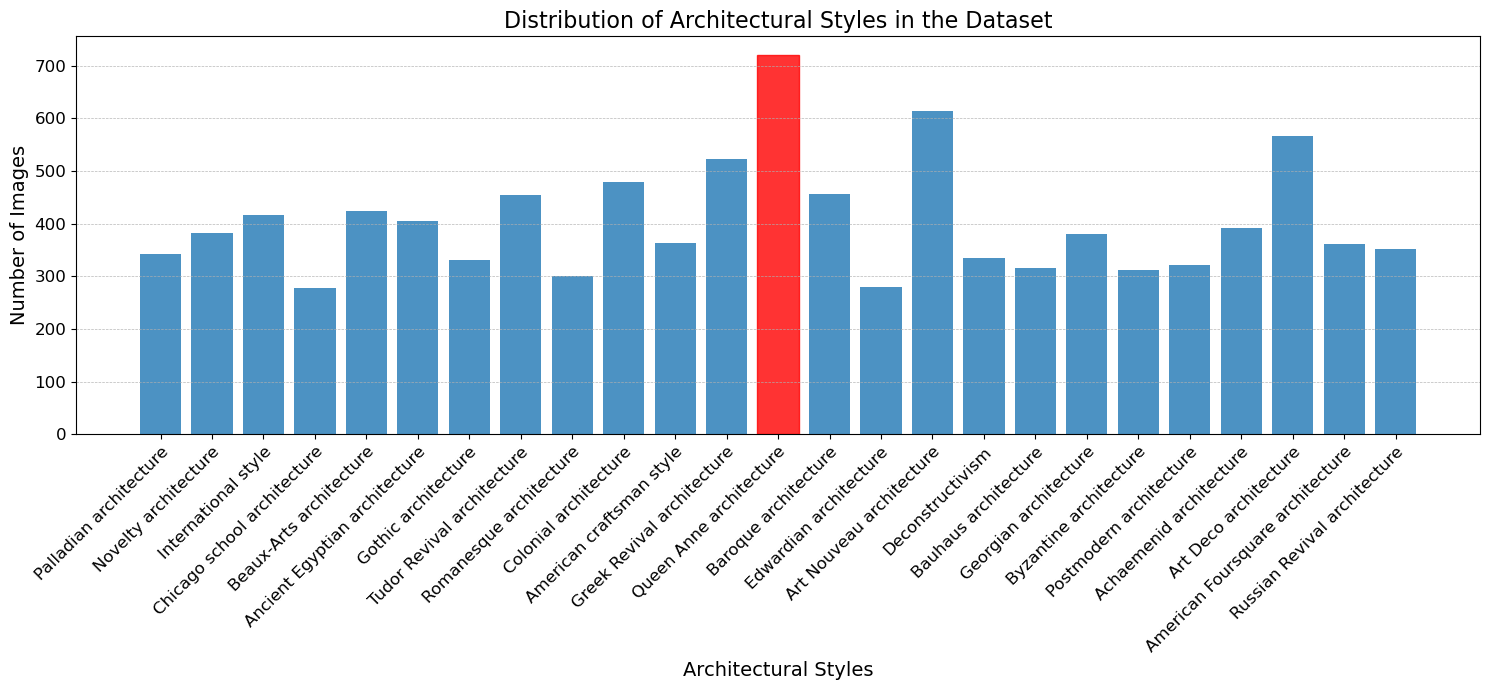

In [13]:
# Set the figure size and color for the bars
plt.figure(figsize=(15, 7))
color = '#1f77b4' 

# Plot the data
bars = plt.bar(style_counts.keys(), style_counts.values(), color=color, alpha=0.8)

# Highlight the bar with the highest value
max_val = max(style_counts.values())
bars[np.argmax(list(style_counts.values()))].set_color('red')

# Set labels, title, and add grid
plt.xlabel('Architectural Styles', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12, rotation_mode='anchor')
plt.yticks(fontsize=12)
plt.title('Distribution of Architectural Styles in the Dataset', fontsize=16)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.9)

# Use tight layout to ensure everything fits
plt.tight_layout()

# Display the graph
plt.show()


In [17]:
# Initialize variables
dimensions = set()
color_types = set()
dimension_distribution = {}

# Analyze images
for style in styles:
    for image_file in os.listdir(os.path.join(DATA_PATH, style)):
        if not image_file.startswith('.'):
            image_path = os.path.join(DATA_PATH, style, image_file)
            with Image.open(image_path) as img:
                # Dimensions
                dimensions.add(img.size)
                
                # Color type (grayscale or RGB)
                color_types.add(img.mode)
                
                # Distribution of dimensions
                if img.size in dimension_distribution:
                    dimension_distribution[img.size] += 1
                else:
                    dimension_distribution[img.size] = 1

print(f"Unique image dimensions in dataset: {len(dimensions)}")
print(f"Image color modes in dataset: {color_types}")



Unique image dimensions in dataset: 3344
Image color modes in dataset: {'RGB', 'L', 'CMYK'}


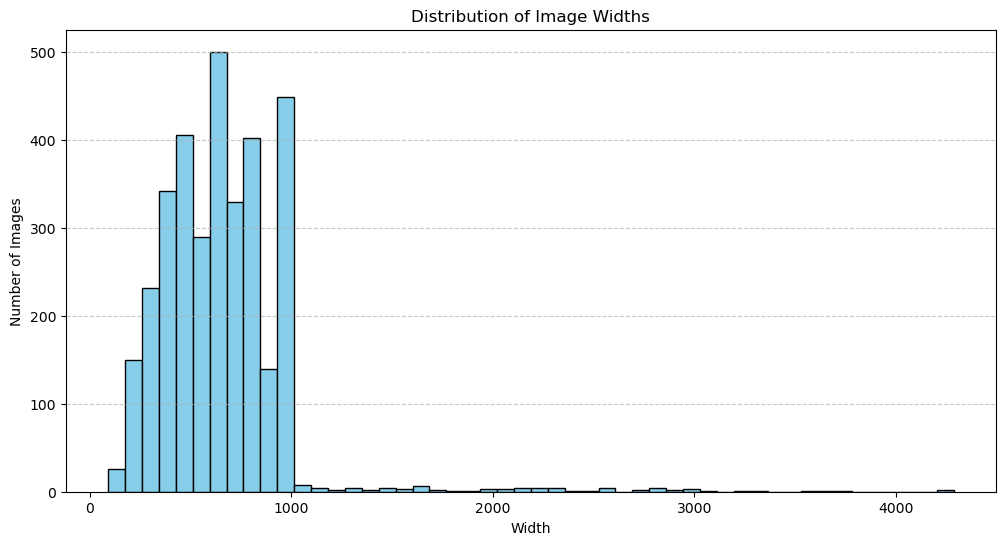

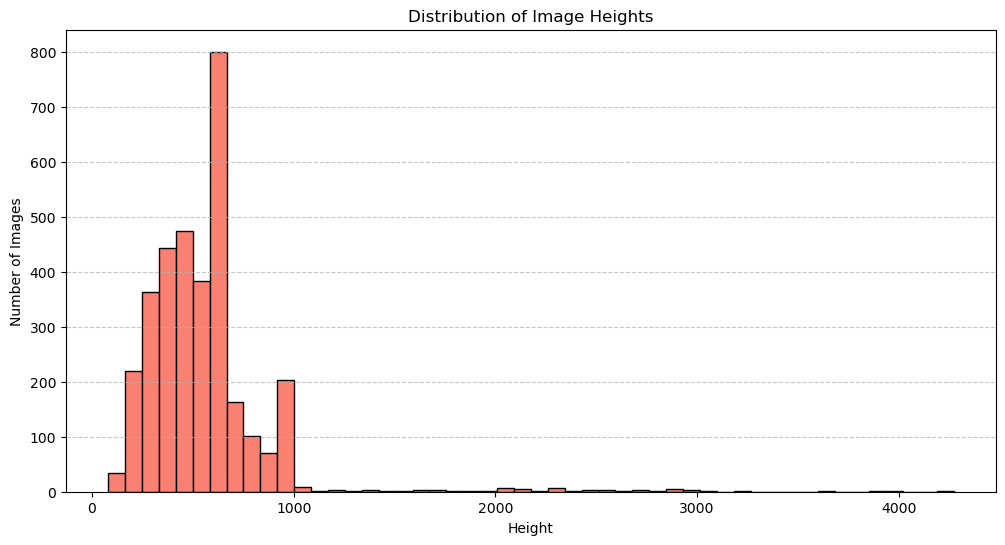

In [18]:
import matplotlib.pyplot as plt

# Continue from the code provided earlier

# Separate out widths and heights from the dimensions
widths = [dim[0] for dim in dimensions]
heights = [dim[1] for dim in dimensions]

# Plotting the distribution of widths
plt.figure(figsize=(12, 6))
plt.hist(widths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Image Widths')
plt.xlabel('Width')
plt.ylabel('Number of Images')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plotting the distribution of heights
plt.figure(figsize=(12, 6))
plt.hist(heights, bins=50, color='salmon', edgecolor='black')
plt.title('Distribution of Image Heights')
plt.xlabel('Height')
plt.ylabel('Number of Images')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
